## Functions

In [ ]:
fontsize = 13

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Forecast models
#!pip install -U statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import *
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.feature_extraction import  *
from sklearn.base import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.svm import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.neighbors import *
from imblearn.over_sampling import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# Tensorflow
import tensorflow as tf
from keras.models import Sequential
from keras.models import *
from keras.layers import LSTM
from keras.layers import *
!pip install scikeras
from scikeras.wrappers import KerasClassifier

# Warnings
import warnings

# To register elapsed time
import time

# Save objects to files
import pickle

# Read files
import glob

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Drive path
  %cd $drive_path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "liner"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df

##### Transform data series

In [ ]:
# Apply differences to a time series panda dataframe
def diff_time_series_df(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df


# Apply differences to a time series panda series
def diff_time_series(df, diff_order):
  
  # diff_order - how many times data must be differenced

  df = df.copy()

  for order in range(diff_order):
    df = df.diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [ ]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value, interpolation_method):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  n_samples = df.groupby(id)[value].size()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = [id])["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes
  
  df = pd.concat([df, n_samples], axis = 1)
  df.columns = ["n_changes", "n_samples"]

  return df, product_id_ord

##### Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  # The interpolate methods that I used were either "linear" (linear interpolation) or "ffill" (repeat last value)
  return df.copy().interpolate(method = method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price):

  df = df.copy()

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro"):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price)

##### Performance Metrics

In [ ]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

In [ ]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Test stationarity

In [ ]:
def adf_test_results(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.round(4))


def kpss_test_results(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


def adf_test(timeseries, p_value_max):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput["is_stationary"] = (dfoutput.loc["p-value"] < p_value_max)

    return dfoutput

def kpss_test(timeseries, p_value_max):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3],
        index=[
               "Test Statistic",
               "p-value",
               "Lags Used"
               ]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    kpss_output["is_stationary"] = (kpss_output.loc["p-value"] > p_value_max)

    return kpss_output


def test_stationarity(timeseries, stationary_tests, p_values_max):
  
  is_stationary = []
  p_values = []
  test_results = []

  for stationary_test, p_value_max in zip(stationary_tests, p_values_max):
    test_result = stationary_test(timeseries, p_value_max)
    is_stationary.append(test_result.loc['is_stationary'])
    p_values.append(test_result.loc['p-value'])
    test_results.append(test_result)

  print("P-Values: ", p_values)

  is_overall_stationary = all(is_stationary)
  if is_overall_stationary:
    print("The timeseries is stationary.")
  else:
    print("Can't confirm the series is stationary.")

  return p_values, test_results, is_stationary, is_overall_stationary

##### Linear models

In [ ]:
def get_lags(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  timeseries_diff = diff_time_series(timeseries, diff_order)
  acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha)
  pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)

  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1]-acf_coeff)   | (acf_coeff  < acf_confint[:,0]-acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]-pacf_coeff) | (pacf_coeff < pacf_confint[:,0]-pacf_coeff)).astype(int))

  return acf_lags, pacf_lags

In [ ]:
def plot_results(title, obs, pred, confint, fig_size):
    
    # Graph
    fig, ax = plt.subplots(figsize=(fig_size))
    ax.set(title=title, xlabel='Date', ylabel='Price/€')

    # Plot data points
    obs.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    if confint != None:
      ci = confint
      ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower right')
    #ax.set_ylim([min(obs)-100, max(obs)+100])

##### Naive models

In [ ]:
class EXPONENTIAL_SMOOTHING:
  def __init__(self):
    pass

  def get_prediction(self, data, smoothing_level):
    
    self.data = data.copy()
    self.beg = 11

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = SimpleExpSmoothing(self.data.iloc[:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast()

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')

    legend = ax.legend(loc='lower right')

##### Characteristics of timeseries

In [ ]:
def get_variance(series):
  return np.sum((series - np.mean(series))**2)/len(series)

##### Strings

In [ ]:
def add_pre_suf(word, pre_suf, pre_suf_flag):
  if pre_suf_flag == "pre":
    return pre_suf + word
  elif pre_suf_flag == "suf":
    return word + pre_suf
  else:
    return word

##### Save figure

In [ ]:
def save_fig(plt, chapter_name, section_name, name_of_fig):
  path = 'Dissertação/Chapters/Imagens/Chapter_' + chapter_name + "/" + str.lower(chapter_name) + "_" + str.lower(section_name) + "_" + name_of_fig + "."
  print(path)
  plt.savefig(path + "svg")
  plt.savefig(path + "png", bbox_inches = "tight")
  plt.savefig(path + "pdf")

# Notebook: Models for Price Change Prediction
- **Goal**: implementation of non-linear models for short-term prediction of price changes (SVM, Logistic Regression, RF)

In [ ]:
mount_drive_select_path()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/UA/5º Ano/Tese


## OLD - Read Data

#### Read data

In [ ]:
#zip_name = "data/catalog_sample.zip"
#file_name = "catalog_sample.json"
#filetype = "json"
#df_og = zip_2_dataframe(zip_name, file_name, filetype)
df_og = pd.read_pickle("df_og")

NameError: ignored

#### Clean data and add unique identifiers to products, product groups and companies

In [ ]:
#df = clean_data(df_og.copy())
#df = add_ids(df)
df = pd.read_pickle("df_clean")

In [ ]:
df

,country_company,company_id,product_group_id,product_id,product,country,company,price,timestamp,offer_type,currency,price_clean,price_euro
0,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-22,unlocked,$,799.99,727.726735
1,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-21,unlocked,$,799.99,727.726735
2,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-20,unlocked,$,799.99,727.726735
3,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-19,unlocked,$,799.99,727.726735
4,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-18,unlocked,$,799.99,727.726735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602051,CL claro,19,958,3222,huawei Y9S 128GB,CL,claro,"$229,990",2020-06-21,unlocked,$,229.99,209.214955
602052,CO Claro,5,958,3234,huawei Y9S 128GB,CO,Claro,"$1,168,900",2020-06-21,unlocked,$,1168.90,1063.313017
602053,CO Tigo,3,958,3228,huawei Y9S 128GB,CO,Tigo,"$1,079,900",2020-06-21,unlocked,$,1079.90,982.352406
602054,PE Movistar,23,960,3236,huawei Y9S 128GB,PE,Movistar,"S/1,519",2020-06-20,postpaid_portability,S,1519.00,364.560000


#### Interpolate data

In [ ]:
id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

#df_inter = df[[id, value, time]].sort_values([id, time])                         
#df_inter = df_inter.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})
#df_inter.to_pickle("df_inter_fill")
df_inter = pd.read_pickle("df_inter_fill")

#### Order products by number of changes in time series

In [ ]:
#df_changes_linear, product_id_ord_linear = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "linear")
#df_changes_fill, product_id_ord_fill = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "ffill")

#counts = []
#for i in range(min(df_changes_fill["n_changes"]), max(df_changes_fill["n_changes"])):
#  counts.append(len(df_changes_fill["n_changes"][df_changes_fill["n_changes"] > i]))

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
#ax.plot(counts)
#plt.title("Nº of examples that have more than a certain number of changes")

#df_changes_linear.to_pickle("df_changes_linear")
#df_changes_fill.to_pickle("df_changes_fill")
#np.save("product_id_ord_linear", product_id_ord_linear)
#np.save("product_id_ord_fill", product_id_ord_fill)

In [ ]:
df_changes_linear = pd.read_pickle("df_changes_linear")
df_changes_fill = pd.read_pickle("df_changes_fill")
product_id_ord_linear = np.load("product_id_ord_linear.npy")
product_id_ord_fill = np.load("product_id_ord_fill.npy")

#### Visualize time series

In [ ]:
product_id = [product_id_ord_fill[150]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  165


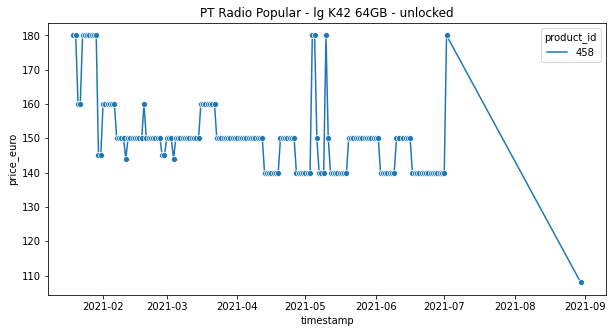

In [ ]:
show_time_series(df_product, "product_id", info)

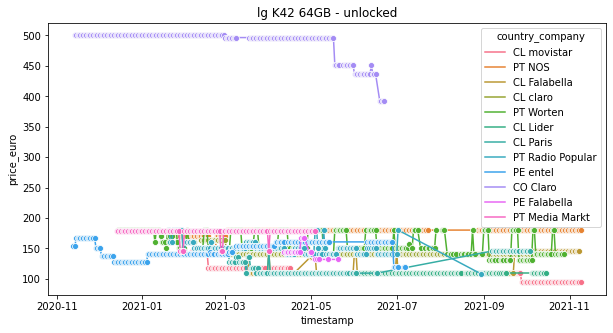

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

Text(0.5, 1.0, 'Differencing Order: 1')

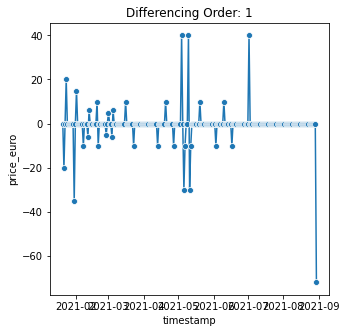

In [ ]:
product_id = [product_id_ord_fill[150]]

df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

diff_order = 1
df_diff = diff_time_series_df(df_product, diff_order, columns = "price_euro")

# Difference
set_fig_size((5, 5))
sns_line = sns.lineplot(x = "timestamp", y = "price_euro", data = df_diff, marker = 'o')
sns_line.set_title("Differencing Order: " + str(diff_order))

## Read data

In [ ]:
# -1 -> down
#  0 -> same
#  1 -> up
#  2 -> missing

In [ ]:
df_all = pd.read_pickle("df_all").reset_index().set_index("product_id")
df_all["states"] = df_all["states"] - 1

n_samples = df_all.dropna().groupby(by = "product_id").count().price_euro
n_changes = df_all.dropna()["diff"]
n_changes = n_changes[n_changes != 0].groupby(by = "product_id").count()
n_samples = n_samples.loc[n_changes.index]

n_changes_flt = n_changes[n_changes > 5]
n_samples_flt = n_samples.loc[n_changes_flt.index]
n_samples_flt = n_samples_flt[n_samples_flt > 90]
n_changes_flt = n_changes_flt.loc[n_samples_flt.index]
n_samples_flt.name = "n_samples"
n_changes_flt.name = "n_changes"

df_all_flt = df_all.loc[n_changes_flt.index]
df_all_flt = df_all_flt.reset_index().merge(pd.DataFrame(n_samples_flt).reset_index(), on = "product_id", how = "left").merge(pd.DataFrame(n_changes_flt).reset_index(), on = "product_id", how = "left").drop_duplicates().set_index("product_id")
df_all_flt["changes_samples_ratio"] = df_all_flt["n_changes"]/df_all_flt["n_samples"]

#### Get discrete data

In [ ]:
def get_discrete_df(df, features, lags, univariate_multivariate):
  regressors = []
  for feature in features:
    for lag in range(1, lags+1):
      regressor = feature + "_lag_" + str(lag)
      df[regressor] = df.groupby(by = "product_id")[feature].shift(lag)
      regressors.append(regressor)
  return df, regressors

def get_X_y(df, features, lags, filter_missing_values = True):

  df = df.copy()

  univariate_multivariate = 0

  df, regressors = get_discrete_df(df, features, lags, univariate_multivariate)
  df = df.dropna()
  y = df["states"]
  X = df[regressors]
  if filter_missing_values:
    y = y[(X != 2).apply(all, axis = 1)]
    X = X[(X != 2).apply(all, axis = 1)]
    X = X[y != 2]
    y = y[y != 2]

  return X, y

#product_id = 1
#X, y = get_X_y(df_all, ["states"], 2)

#### Visualize data

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_price_change_visualizeTimeSeries.


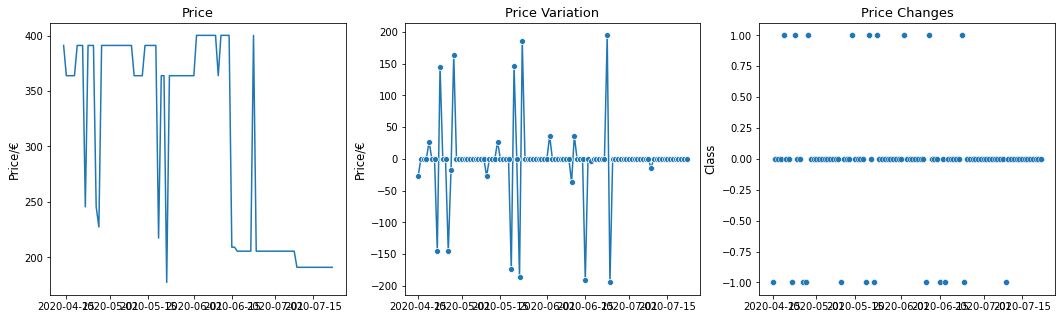

In [ ]:
product_id_list = list(df_all.index.unique())
data = df_all.loc[product_id_list[9]].reset_index(drop = True)

set_fig_size((18, 5))
fig, ax = plt.subplots(1, 3)
p = sns.lineplot(data = data, x = "timestamp", y = "price_euro", ax = ax[0])
p.set_title("Price", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Price/€", fontsize = fontsize - 1.5)

p = sns.lineplot(data = data, x = "timestamp", y = "diff", marker = 'o', ax = ax[1])
p.set_title("Price Variation", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Price/€", fontsize = fontsize - 1.5)

p = sns.scatterplot(data = data, x = "timestamp", y = "states", ax = ax[2])
p.set_title("Price Changes", fontsize = fontsize)
p.set_xlabel("")
p.set_ylabel("Class", fontsize = fontsize - 1.5)

#save_fig(plt, chapter_name = "Prediction", section_name = "price_change", name_of_fig = "visualizeTimeSeries")

## Dimensionality Reduction - LDA and RF

In [ ]:
def plot_dim_reduction(X, y, ax = None, title = "LDA", alpha = 0.5, palette= []):
  
  if X.shape[1] > 1:
    data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1)
    data.columns = ["Feature 1", "Feature 2", "Price Change"]
    data["Price Change"] = data["Price Change"].astype("category").replace([0, -1, 1], ["Same", "Fall", "Rise"])
    h = sns.scatterplot(data = data, x = "Feature 1", y = "Feature 2", hue = "Price Change", ax = ax, alpha = alpha, palette=palette)
    h.set_title(title)
    h.set_xlim(-10, None)
    h.set_ylim(-10, 10)

  else:
    filler = ["y"]*len(y)
    data = pd.concat([pd.DataFrame(X), pd.DataFrame(filler), pd.DataFrame(y)], axis = 1)
    data.columns = ["feat1", "feat2", "class"]
    data["class"] = data["class"].astype("category")
    h = sns.stripplot(data = data, x = "feat1", y = "feat2", hue = "class", ax = ax)
    h.set_title(title)

    plt.tight_layout()

  return h

In [ ]:
X, y = get_X_y(df_all_flt, ["states", "diff"], 14)
y = y.to_numpy()
pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components = 2))
X_lda = pipe_lda.fit(X, y).transform(X)

In [ ]:
idx = np.random.choice(np.arange(len(X_lda)), 15000, replace=False)
X_lda_sample = X_lda[idx]
y_sample = y[idx]

In [ ]:
X, y = get_X_y(df_all_flt, ["states", "diff"], 14)
y = y.to_numpy()
pipe_lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components = 2))
X_lda = pipe_lda.fit(X, y).transform(X)

X_lda_flt = X_lda[y != 0]
y_flt = y[y != 0]

idx = np.random.choice(np.arange(len(X_lda)), 70000, replace=False)
X_lda_sample = X_lda[idx]
y_sample = y[idx]

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_price_change_LDA.


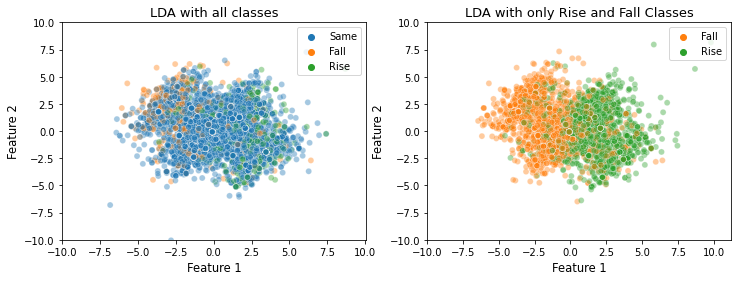

In [ ]:
classes = ["Same", "Fall", "Rise"]
colors = sns.color_palette(None, len(classes))
palette = {mode: color for mode, color in zip(classes, colors)}

set_fig_size((12,4))
fig, ax = plt.subplots(1, 2)
p = plot_dim_reduction(X_lda_sample, y_sample, alpha = 0.4, ax = ax[0], palette=palette)
p.set_title("LDA with all classes", fontsize = fontsize)
p.set_xlabel("Feature 1", fontsize = fontsize - 1.5)
p.set_ylabel("Feature 2", fontsize = fontsize - 1.5)
p.legend(loc = "upper right")

p = plot_dim_reduction(X_lda_flt, y_flt, alpha = 0.4, ax = ax[1], palette=palette)
p.set_title("LDA with only Rise and Fall Classes", fontsize = fontsize)
p.set_xlabel("Feature 1", fontsize = fontsize - 1.5)
p.set_ylabel("Feature 2", fontsize = fontsize - 1.5)
p.legend(loc = "upper right")

save_fig(plt, chapter_name = "Prediction", section_name = "price_change", name_of_fig = "LDA")

In [ ]:
def format_index(index):
  
  new_index = []
  for elem in index:

    strings = elem.split("_")
    if strings[0] == "diff":
      strings[0] = "Price Variation" 
    elif strings[0] == "states":
      strings[0] = "Price Change"
    elif strings[0] == "price":
      strings[0] = "Price"

    strings[0] = strings[0] + " - Lag " + strings[-1]
    new_index.append(strings[0])
      
  return new_index

In [ ]:
def plot_feature_importance(rf, features_name_list, title = None, ax = None):
  #feature_imp = pd.Series(rf.feature_importances_, index = range(len(rf.feature_importances_), 0, -1)).sort_values(ascending=False)
  feature_imp = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending=False)
  sns.barplot(x=format_index(feature_imp.index), y=feature_imp, ax = ax)
  if ax == None:
    plt.xlabel('Features', fontsize=fontsize-1.5)
    plt.ylabel('Importance Score', fontsize=fontsize-2)
    plt.title(title, fontsize=fontsize, pad=10)
    plt.tick_params(labelrotation=90)
  else:
    ax.set_xlabel('Feature Importance Score', fontsize=8)
    ax.set_ylabel('Features', fontsize=8)
    ax.set_title(title, fontsize=10, pad=10)

In [ ]:
X, y = get_X_y(df_all_flt, ["states", "price_euro", "diff"], 14)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, bootstrap=True, n_jobs=-1, random_state=0)
rf.fit(X, y)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=0)

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_price_change_dimensionalityReduction.


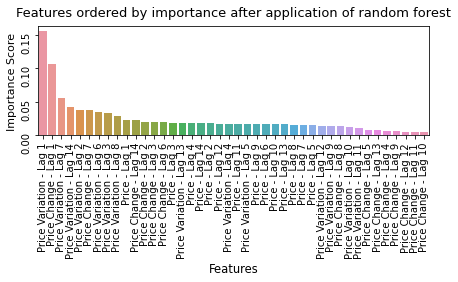

In [ ]:
set_fig_size((7, 2))
plot_feature_importance(rf, X.columns, title = "Features ordered by importance after application of random forest")
save_fig(plt, chapter_name = "Prediction", section_name = "price_change", name_of_fig = "dimensionalityReduction")

## Models

#### Baseline

In [ ]:
class BASELINE:

  def __init__(self, n_states = 3):
    self.n_states = n_states

  # Fit
  def fit(self, X, y):

    # Check that X and y have correct shape
    X, y = check_X_y(X, y)

    # Store the classes seen during fit
    self.classes_ = unique_labels(y)

    # Return the classifier
    return self

  # Predict
  def predict(self, X):
    
    # Input validation
    check_array(X)
    
    # Get predictions
    self.y_pred = np.zeros(len(X))

    return self.y_pred

#### ML Models

In [ ]:
def get_model_stats(X, y, model, param_grid, cv, display_confusion_matrix, scoring, classes = []):
  
  model_grid = GridSearchCV(model, param_grid, cv = cv, scoring = scoring)   
  model_grid.fit(X, y)

  cross_val_score = model_grid.best_score_
  best_params = model_grid.best_params_

  y_pred = cross_val_predict(model_grid, X, y, cv = cv)
  y_true = y
  conf_mat = confusion_matrix(y_true, y_pred)
  #class_report = classification_report(y_true, y_pred, target_names=classes, output_dict = True)
  class_report = classification_report(y_true, y_pred, output_dict = True)

  return model_grid, cross_val_score, best_params, y_pred, y_true, conf_mat, class_report

In [ ]:
param_grid_log_reg = {'logisticregression__C': [0.1, 10, 100],
                      'logisticregression__penalty': ['l2', "none"]} 

param_grid_svm = {'svc__C': [0.05, 1, 10, 100],
                  'svc__gamma': [0.05, 1, 10, 100],
                  'svc__kernel': ["rbf"]}

param_grid_rf = {'randomforestclassifier__max_depth': [4, 8],
                 'randomforestclassifier__n_estimators': [50]}

param_grids = [param_grid_log_reg, param_grid_svm, param_grid_rf]
param_grids = [param_grid_log_reg, param_grid_rf]

In [ ]:
def get_logistic_regression_stats(X, y, param_grid, class_weight, scoring, cv = 5):
  log_reg = make_pipeline(MinMaxScaler(), PCA(), LogisticRegression(solver = "newton-cg",  class_weight = class_weight))   
  warnings.filterwarnings("ignore")
  model_stats = get_model_stats(X, y, log_reg, param_grid, cv = cv, display_confusion_matrix = False, scoring = scoring, classes = ["Down", "Same", "Up"])
  warnings.filterwarnings("always")
  return model_stats

def get_svm_stats(X, y, param_grid, class_weight, scoring, cv = 5):
  svm = make_pipeline(MinMaxScaler(), SVC(class_weight = class_weight)) 
  warnings.filterwarnings("ignore") 
  model_stats = get_model_stats(X, y, svm, param_grid, cv = cv, display_confusion_matrix = False, scoring = scoring, classes = ["Down", "Same", "Up"])
  warnings.filterwarnings("always")
  return model_stats

def get_rf_stats(X, y, param_grid, class_weight, scoring, cv = 5):
  rf = make_pipeline(RandomForestClassifier(bootstrap=True, n_jobs=-1, random_state=0, class_weight = class_weight))
  warnings.filterwarnings("ignore")
  model_stats = get_model_stats(X, y, rf, param_grid, cv = cv, display_confusion_matrix = False, scoring = scoring, classes = ["Down", "Same", "Up"])
  warnings.filterwarnings("always")
  return model_stats

models_stats = [get_logistic_regression_stats, get_svm_stats, get_rf_stats]
models_stats = [get_logistic_regression_stats, get_rf_stats]

models_names = ["log_reg", "svm", "rf"]
models_names = ["log_reg", "rf"]

In [ ]:
# The input of LSTM layer has a shape of (num_timesteps, num_features)
#https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers

def create_model(input_shape = (7, 1), neurons = 1, n_denses = [3]):
  model = tf.keras.models.Sequential()
  model.add(LSTM(neurons, input_shape = input_shape))
  for n_dense in n_denses:
    model.add(Dense(n_dense))
  #model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"])
  return model

def get_LSTM_stats(X, y, param_grid, class_weight, scoring, cv = 5, input_shape = (7, 1)):
  #warnings.filterwarnings("ignore")
  X = MinMaxScaler().fit_transform(X)
  X = X.reshape((X.shape[0], input_shape[0], input_shape[1]), order = "F")
  y = y.astype(int)
  lstm = Pipeline([('kerasclassifier',  KerasClassifier(model = create_model, epochs = 10, batch_size = 32, verbose = 0,
                                                        neurons = 1, n_denses = [3], 
                                                        input_shape = input_shape, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam"))])
  
  model_stats = get_model_stats(X, y, lstm, param_grid, cv = cv, display_confusion_matrix = False, scoring = scoring, classes = ["Down", "Same", "Up"])
  warnings.filterwarnings("always")
  return model_stats

param_grid_lstm = {'kerasclassifier__neurons': [2, 3],
                   'kerasclassifier__n_denses' : [[3]]}

## Get Predictions

#### Univariate

###### Individual Products

In [ ]:
product_id_list = list(df_all_flt.index.unique())
product_id_list.remove(606)
product_id_list.remove(2548)

In [ ]:
count = 800
class_weight = "balanced"
scoring = "balanced_accuracy"
cv = 5

for count_file in range(8,12):

  print("Count File: ", count_file)
  
  all_info = []                       # store all info of each hyper-paramter for each timeseries

  for product_id in product_id_list[count_file*100:(count_file+1)*100]:

    count = count + 1
    print(count, "/", len(product_id_list))

    # Get data
    data = df_all_flt.loc[product_id]
    X, y = get_X_y(data, ["states", "diff"], 7)

    if (len(y) > 90) & (len(y.unique()) > 1):

      # Get baseline
      baseline = BASELINE()
      y_baseline = baseline.predict(X)
      metric_baseline = np.mean(abs(y_baseline-y))

      for model_stats, param_grid, model_name in zip(models_stats, param_grids, models_names):

        print("Model: ", model_name)
        model_grid, cross_val_score, best_params, y_pred, y_true, conf_mat, class_report = model_stats(X, y, param_grid, class_weight, scoring, cv = cv)

        metric = np.mean(abs(y_pred-y))
        
        info = {"product_id": product_id,
                "company": data.loc[product_id].company.unique()[0],
                "company_id": data.loc[product_id].company_id.unique()[0],
                "product_group_id": data.loc[product_id].product_group_id.unique()[0],
                "country": data.country.unique()[0],
                "product": data["product"].unique()[0],
                "offer_type": data.offer_type.unique()[0],
                "X": X,
                "y": y,
                "y_pred": y_pred,
                "y_baseline": y_baseline,
                "data" : "individual",
                "model" : model_name,
                "n_changes" : data.loc[product_id].n_changes.unique()[0],
                "n_samples" : data.loc[product_id].n_samples.unique()[0],
                "changes_samples_ratio" : data.loc[product_id].changes_samples_ratio.unique()[0],
                "metric": metric,
                "metric_baseline": metric_baseline,
                "compare_metric" : metric - metric_baseline,
                "cross_val_score": cross_val_score,
                "best_params" : best_params,
                "conf_mat": conf_mat,
                "class_report": class_report,
                "cv" : cv}
    
        all_info.append(info)
      
  df_all_info = pd.DataFrame(all_info)
  df_all_info.to_pickle("discrete_approach_non_linear_models_individual_" + str(count_file))

Count File:  8
801 / 1043
Model:  log_reg
Model:  svm
Model:  rf
802 / 1043
Model:  log_reg
Model:  svm
Model:  rf
803 / 1043
Model:  log_reg
Model:  svm
Model:  rf
804 / 1043
Model:  log_reg
Model:  svm
Model:  rf
805 / 1043
806 / 1043
Model:  log_reg
Model:  svm
Model:  rf
807 / 1043
Model:  log_reg
Model:  svm
Model:  rf
808 / 1043
Model:  log_reg
Model:  svm
Model:  rf
809 / 1043
Model:  log_reg
Model:  svm
Model:  rf
810 / 1043
Model:  log_reg
Model:  svm
Model:  rf
811 / 1043
Model:  log_reg
Model:  svm
Model:  rf
812 / 1043
Model:  log_reg
Model:  svm
Model:  rf
813 / 1043
Model:  log_reg
Model:  svm
Model:  rf
814 / 1043
Model:  log_reg
Model:  svm
Model:  rf
815 / 1043
816 / 1043
Model:  log_reg
Model:  svm
Model:  rf
817 / 1043
Model:  log_reg
Model:  svm
Model:  rf
818 / 1043
Model:  log_reg
Model:  svm
Model:  rf
819 / 1043
Model:  log_reg
Model:  svm
Model:  rf
820 / 1043
Model:  log_reg
Model:  svm
Model:  rf
821 / 1043
Model:  log_reg
Model:  svm
Model:  rf
822 / 1043
Mo

In [ ]:
df_all_info_individual = pd.read_pickle("discrete_approach_non_linear_models_individual")

In [ ]:
df_all_info_individual

,product_id,company,company_id,product_group_id,country,product,offer_type,X,y,y_pred,...,n_samples,changes_samples_ratio,metric,metric_baseline,compare_metric,cross_val_score,best_params,conf_mat,class_report,cv
0,2,Movistar,2,2,CO,xiaomi Redmi Note 8 128GB,unlocked,states_lag_1 states_lag_2 states...,product_id 2 0.0 2 0.0 2 0.0 2 0.0...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",...,291,0.027491,0.622951,0.032787,0.590164,0.453901,"{'kerasclassifier__n_denses': [3], 'kerasclass...","[[1, 2, 2], [47, 94, 95], [1, 2, 0]]","{'Down': {'precision': 0.02040816326530612, 'r...",5
1,12,Falabella,1,2,CL,xiaomi Redmi Note 8 128GB,unlocked,states_lag_1 states_lag_2 states...,product_id 12 -1.0 12 1.0 12 0.0 12 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,99,0.212121,0.347826,0.206522,0.141304,0.333333,"{'kerasclassifier__n_denses': [3], 'kerasclass...","[[0, 9, 2], [0, 60, 13], [0, 6, 2]]","{'Down': {'precision': 0.0, 'recall': 0.0, 'f1...",5


###### Same company products

In [ ]:
company_id_list = list(df_all_flt.company_id.unique())

In [ ]:
all_info = []
count = 0
class_weight = "balanced"
scoring = "balanced_accuracy"
cv = 3

for company_id in company_id_list:

  count = count + 1
  print(count, "/", len(company_id_list))

  # Get data
  data = df_all_flt[df_all_flt.company_id == company_id]
  X, y = get_X_y(data, ["states", "diff"], 14)

  if (len(y) > 150) & (len(y.unique()) > 1):

    y = y.to_numpy()

    # Get baseline
    baseline = BASELINE()
    y_baseline = baseline.predict(X)
    metric_baseline = np.mean(abs(y_baseline-y))

    for model_stats, param_grid, model_name in zip(models_stats, param_grids, models_names):

      print("Model: ", model_name)
      model_grid, cross_val_score, best_params, y_pred, y_true, conf_mat, class_report = model_stats(X, y, param_grid, class_weight, scoring, cv = cv)

      # Metrics
      product_id_list = list(data.index.unique())
      #y = y.to_numpy()

      for product_id in product_id_list:

        y_product_id = y[X.reset_index().product_id == product_id]
        y_pred_product_id = y_pred[X.reset_index().product_id == product_id]
        y_baseline_product_id = y_baseline[X.reset_index().product_id == product_id]

        metric = np.mean(abs(y_pred_product_id-y_product_id))
        metric_baseline = np.mean(abs(y_baseline_product_id-y_product_id))
       
        info = {"product_id": product_id,
                "company": data.loc[product_id].company.unique()[0],
                "company_id": data.loc[product_id].company_id.unique()[0],
                "product_group_id": data.loc[product_id].product_group_id.unique()[0],
                "country": data.country.unique()[0],
                "product": data["product"].unique()[0],
                "offer_type": data.offer_type.unique()[0],
                "X": X,
                "y": y,
                "y_pred": y_pred,
                "y_baseline": y_baseline,
                "data" : "individual",
                "model" : model_name + "same_company",
                "n_changes" : data.loc[product_id].n_changes.unique()[0],
                "n_samples" : data.loc[product_id].n_samples.unique()[0],
                "changes_samples_ratio" : data.loc[product_id].changes_samples_ratio.unique()[0],
                "metric": metric,
                "metric_baseline": metric_baseline,
                "compare_metric" : metric - metric_baseline,
                "cross_val_score": cross_val_score,
                "best_params" : best_params,
                "conf_mat": conf_mat,
                "class_report": class_report,
                "cv" : cv}
                
        all_info.append(info)
      
df_all_info_same_company = pd.DataFrame(all_info)
df_all_info_same_company.to_pickle("discrete_approach_non_linear_models_same_company")

NameError: ignored

###### Analyse results

In [ ]:
filenames = ["discrete_approach_non_linear_models_individual",
             "discrete_approach_non_linear_models_same_company"]

all_info = []
for filename in filenames:
  all_info.append(pd.read_pickle(filename))

df_non_linear_univariate = pd.concat(all_info)

In [ ]:
df_non_linear_univariate.groupby(by = "model").compare_metric.mean()

model
log_reg    0.293834
rf         0.159242
svm        0.416107
Name: compare_metric, dtype: float64

#### Multivariate

##### Functions

In [ ]:
def characterize_product_group(product_group_id):
  # High correlation product_group_id : 8 153 245 335 349 413 529 427 551 554 557 601
  # High correlation but short: 23 921 199
  # Hight correlation but just between retailers: 179  278 405 563 574
  # Hight correlation but just between operators: 370 381
  # Low correlation: 120 417 421 424 435 437 468 594
  # Low correlation and short: 189 923

  if product_group_id in  [8, 153, 245, 335, 349, 413, 529, 427, 551, 554, 557, 601]:
    return "high_correlation_all"
  elif product_group_id in [179, 278, 405, 563, 574]:
    return "high_correlation_retailers"
  elif product_group_id in [370, 381]:
    return "high_correlation_operators"
  elif product_group_id in [417, 424, 435, 437, 468, 594]:
    return "low_correlation_all"

# Determine if company is retailer or operator
def is_retailer_operator(company, country):
  if country == "PT":
    if company in ["Worten", "Radio Popular", "Media Markt"]:
      return "retailer"
    elif company in ["Vodafone", "MEO", "NOS"]:
      return "operator"

# Get number of changes of individual timeseries
def get_n_changes(timeseries):
  n_changes = timeseries.diff().dropna()
  n_changes = len(n_changes[n_changes != 0])
  return n_changes

# Select only the products from product_group_id and remove the timeseries that make the whole group too short. These timeseries were found manually, by visual inspection.
def select_df_product_group_id(df, product_group_id):
  df_product_group_id = df[df.product_group_id == product_group_id]
  companies = list(df_product_group_id.company.unique())

  if product_group_id in [8, 153, 245, 468, 551, 557]:
    companies.remove("NOS")
  elif product_group_id in [278]:
    companies.remove("Radio Popular")
  elif product_group_id in [574, 437]:
    companies.remove("Vodafone")
    companies.remove("NOS")

  df_product_group_id = df_product_group_id[df_product_group_id.company.isin(companies)]

  return df_product_group_id

# Get list of companies to be considered when doing prediction
def get_companies(company, existing_companies, all, self, min_max):
  
  retailers = ["Worten", "Radio Popular", "Media Markt"]
  operators = ["Vodafone", "MEO", "NOS"]
  
  if all == "all":
    companies = retailers + operators
  elif company in retailers:
    companies = retailers
  elif company in operators:
    companies = operators

  if self != "self":
    companies.remove(company)

  if min_max == "min_max":
    companies = companies + ["min_" + company, "max_" + company]

  if self == "just_self":
    companies = [company]
  
  companies = [company for company in companies if company in existing_companies]

  return companies

# Get all lagged timeseries that are relevant
def get_features_df_product_group_id(df_product_group_id, feature_types, max_lag, min_lag = 1):

  # Lag timeseries
  for feature_type in feature_types:
    for lag in range(min_lag, max_lag+1):
      df_product_group_id[feature_type + "_lag_" + str(lag)] = df_product_group_id.groupby(by = "product_id")[feature_type].shift(lag)

  df_product_group_id = df_product_group_id.dropna()

  # Missing values
  # df_product_group_id["price_euro_mv"] = df_product_group_id["price_euro"].where(df_product_group_id["out_of_stock"] == 0, np.nan)

  return df_product_group_id 

def prepare_prophet_data(df_product_group_id, company, y_type, min_lag):
  
  # Unstack
  df_product_group_id_unstack = df_product_group_id.reset_index().set_index(["company", "timestamp"])
  df_product_group_id_unstack = df_product_group_id_unstack.unstack(level=[0]).dropna()
  df_product_group_id_unstack.columns = list(map(lambda x : '_'.join((x[1], x[0])), df_product_group_id_unstack.columns))

  # Select ds and y
  data = df_product_group_id_unstack.reset_index()
  data["ds"] = data["timestamp"]
  data["y"] = data[company + y_type]
  return data

def generate_regressors(companies, feature_types, max_lag, min_lag = 1):
  regressors = []
  for company in companies:
    for feature in feature_types:
      for lag in range(min_lag, max_lag+1):
        regressor = company + "_" + feature
        if lag != 0:
          regressor = regressor + "_lag_" + str(lag)
        regressors.append(regressor)

  return regressors

def get_prophet_model(df_product_group_id, max_lag, company, hyper_parameters, min_lag = 1):
  
  y_type = "_price_euro"

  # Get prophet data
  data = prepare_prophet_data(df_product_group_id, company, y_type, min_lag)

  # Get regressors
  existing_companies = list(df_product_group_id.company.unique())
  companies = get_companies(company, existing_companies, hyper_parameters["included_companies"][0], hyper_parameters["included_companies"][1], hyper_parameters["included_companies"][2])
  feature_types = hyper_parameters["feature_types"]
  regressors = generate_regressors(companies, feature_types, max_lag, min_lag)

  return data, m

In [ ]:
# usar para cada grupo as melhores features do random forest

In [ ]:
df_country = df_all[df_all.country == "PT"]

In [ ]:
# Features
prediction_horizon = 1
lag_interval = 14
min_lag = prediction_horizon
max_lag = (min_lag - 1) + lag_interval

feature_types = ["diff", "states"]

init_count_list = list(range(12, 17, 2))
end_count_list = list(range(13, 18, 2))

init_count_list = [0]
end_count_list = [24]

# Timeseries that weren't included in this list either were to short or had only one or two companies associated to a certain product. This will make it easier to analyse, with less simulations the impact of other timeseries
product_group_id_lst_multi = [8, 153, 245, 349, 413, 529, 427, 551, 554, 557, 601, 179, 278, 405, 563, 574, 370, 381, 417, 424, 435, 437, 468, 594]

for init_count, end_count in zip(init_count_list, end_count_list):
  
  all_info = []                       # store all info of each hyper-paramter for each timeseries
  count = init_count-1

  for product_group_id in product_group_id_lst_multi[init_count:end_count+1]:

    count = count + 1

    # Select product_group_id
    df_product_group_id = select_df_product_group_id(df_country, product_group_id)
    df_product_group_id = get_features_df_product_group_id(df_product_group_id, feature_types, max_lag, min_lag)

    companies = [company for company in list(df_product_group_id.company.unique()) if not any(bad in company for bad in ["min", "max"])]

    print("Count: ", count)
    print("Product Group ID: ", product_group_id)
    print("Existing companies: ", companies)
    
    for company in companies:

      print("\tCompany: ", company)
      
      # Get product basic informations
      product_id = df_product_group_id[df_product_group_id.company == company].index.get_level_values(0).unique()[0]

      base_info = {"product_id": product_id,
                   "company": company,
                   "company_id": df_product_group_id.loc[product_id].company_id.unique()[0],
                   "product_group_id": product_group_id,
                   "country": df_product_group_id.country.unique()[0],
                   "product": df_product_group_id["product"].unique()[0],
                   "offer_type": df_product_group_id.offer_type.unique()[0],
                   "product_group_characteristic": characterize_product_group(product_group_id),
                   "companies": companies,
                   "n_companies": len(companies),
                   "type_company": is_retailer_operator(company, df_product_group_id.country.unique()[0])}


      # Get prophet model
      
      data, m = get_prophet_model(df_product_group_id, max_lag, company, values, min_lag)
      forecast = m.predict(data)
      df_cv = cross_validation(m, initial = str(initial) + 'days', period = str(period) + 'days', horizon = str(horizon) + 'days', parallel = "dask") 

      # Metrics
      df_p = performance_metrics(df_cv)
      nmse = get_nmse(df_cv["y"], df_cv["yhat"])

      # Regressor coeficients
      df_regressor_coefficients = get_regressor_coefficients(m)

      # Saving results
      new_info = {"n_samples": len(data["y"]),
                  "n_changes": get_n_changes(data["y"]),
                  "forecast": forecast,
                  "model": m,
                  "hyper_parameters": values.copy(),
                  "cross_validation_results": df_cv,
                  "performance_metrics" : df_p,
                  "nmse": nmse,
                  "regressor_coefficients": df_regressor_coefficients,
                  "cross_validation_initial": initial,
                  "cross_validation_period": period,
                  "cross_validation_horizon": horizon,
                  "prediction_horizon": prediction_horizon,
                  "min_lag": min_lag,
                  "max_lag": max_lag}

      info = base_info.copy()
      info.update(new_info)
      all_info.append(info)
      
  df_all_info = pd.DataFrame(all_info)
  df_all_info.to_pickle("prophet_predictions_multivariate_all_info_lags_5_initial_" + str(initial) + "_prediction_horizon_" + str(prediction_horizon) + "_" + str(init_count) + "_" + str(end_count))